In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pymystem3 import Mystem
import re
from collections import Counter

In [379]:
# sep - разделитель колонок; decimal - разделитель дробей
df = pd.read_csv('C:/Users/atche/real_estate_data.csv',  sep='	' , decimal='.')
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [380]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

Просмотр пропущенных значений

In [381]:
df.isna().sum().to_frame(name = "nans").query("nans > 0")["nans"]

ceiling_height          9195
floors_total              86
living_area             1903
is_apartment           20924
kitchen_area            2278
balcony                11519
locality_name             49
airports_nearest        5542
cityCenters_nearest     5519
parks_around3000        5518
parks_nearest          15620
ponds_around3000        5518
ponds_nearest          14589
days_exposition         3181
Name: nans, dtype: int64

Высоту потолков (ceiling_height) можно заменить медианой (которая более устойчива к выбросам).
Пропущенные значения параметров is_apartment, balcony заменим нулем. 

In [382]:
df.ceiling_height.describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

In [383]:
df = df.sort_values(by = 'ceiling_height', ascending = True)
df = df.fillna({'ceiling_height': df.ceiling_height.median()})
df = df.sort_index(ascending = True)

In [384]:
df['is_apartment'] = df['is_apartment'].fillna(0)
df['balcony'] = df['balcony'].fillna(0)

Заменим тип данных на int у значений признаков last_price, floors_total, balcony, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition. Значения части из перечисленных признаков можно округлить до целого числа для удобства. Другие значения не могут быть дробными (например, количество этажей).

In [385]:
df.floors_total.describe()

count    23613.000000
mean        10.673824
std          6.597173
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

In [386]:
df = df.astype({'last_price' : 'Int64', 'floors_total': 'Int64', 'balcony' : 'Int64', 'airports_nearest': 'Int64',
                'cityCenters_nearest': 'Int64', 'parks_around3000': 'Int64', 'parks_nearest': 'Int64', 
                'ponds_around3000': 'Int64', 'ponds_nearest': 'Int64'})

In [387]:
df['days_exposition'] = np.around(df.days_exposition)
df['days_exposition'] = df.days_exposition.astype('Int64')

Значения признака first_day_exposition необходимо привести к типу datetime; значения признаков is_apartment, studio, open_plan - к int.

In [388]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'])

In [389]:
df['is_apartment'] = df.is_apartment.astype('bool')

In [390]:
df = df.astype({'is_apartment': 'int64', 'studio': 'int64', 'open_plan': 'int64'})

In [391]:
df.dtypes

total_images                     int64
last_price                       Int64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                     Int64
living_area                    float64
floor                            int64
is_apartment                     int64
studio                           int64
open_plan                        int64
kitchen_area                   float64
balcony                          Int64
locality_name                   object
airports_nearest                 Int64
cityCenters_nearest              Int64
parks_around3000                 Int64
parks_nearest                    Int64
ponds_around3000                 Int64
ponds_nearest                    Int64
days_exposition                  Int64
dtype: object

Необходимо удалить лишние слова из признака locality_name, такие как "поселок", "деревня".

In [392]:
df.locality_name.value_counts()

Санкт-Петербург                      15721
посёлок Мурино                         522
посёлок Шушары                         440
Всеволожск                             398
Пушкин                                 369
Колпино                                338
посёлок Парголово                      327
Гатчина                                307
деревня Кудрово                        299
Выборг                                 237
Петергоф                               201
Сестрорецк                             183
Красное Село                           178
Кудрово                                173
деревня Новое Девяткино                144
Сертолово                              142
Ломоносов                              133
Кириши                                 125
Сланцы                                 112
Волхов                                 111
Тосно                                  104
Кингисепп                              104
Кронштадт                               96
Никольское 

Проверим частоту встречания слов в признаке locality_name

In [393]:
df_1 = pd.DataFrame(df.locality_name.str.split(expand = True).stack().value_counts())
df_1.reset_index(level = 0, inplace = True)
df_1.columns = ['word', 'freq']
df_1 = df_1[df_1['freq'] >= 0]
with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    print(df_1)

                word   freq
0    Санкт-Петербург  15721
1            посёлок   2108
2            деревня    945
3             Мурино    590
4            поселок    552
5            Кудрово    472
6             Шушары    440
7         Всеволожск    398
8             Пушкин    369
9         городского    363
10              типа    363
11           Колпино    338
12         Парголово    327
13           Гатчина    307
14            Выборг    237
15          Петергоф    201
16         городской    187
17        Сестрорецк    183
18           Красное    178
19              Село    178
20             Новое    144
21         Девяткино    144
22         Сертолово    142
23         Ломоносов    133
24            Кириши    125
25             Бугры    114
26            Сланцы    112
27            Волхов    111
28         Кингисепп    104
29             Тосно    104
30               Бор    101
31         Кронштадт     96
32        Никольское     94
33          Коммунар     89
34          Сосновый

Оставим в df_1 только те слова, которые нам необходимо удалить из df (строки 1, 2, 4, 9, 10, 16, 54, 158, 186, 212, 254, 285).

In [394]:
df_1 = df_1.iloc[[1, 2, 4, 9, 10, 16, 54, 158, 186, 212, 254, 285]]

In [395]:
df_1

,word,freq
1,посёлок,2108
2,деревня,945
4,поселок,552
9,городского,363
10,типа,363
16,городской,187
54,село,32
158,товарищество,5
186,садовое,4
212,коттеджный,3


In [396]:
df.locality_name = df.locality_name.replace('|'.join(df_1['word']), '', regex=True).str.strip()

Необходимо посчитать и добавить в таблицу следующие колонки: цена квадратного метра; день недели, месяц и год публикации объявления; этаж квартиры — первый, последний, другой; соотношение жилой и общей площади; отношение площади
кухни к общей.

day_of_week: 0 - понедельник, 1 - вторник, 2 - среда, 3 - четверг, 4 - пятница, 5 - суббота, 6 - воскресенье.

floor_1: 0 - первый, 1 - последний, 2 - другой.

In [397]:
df['price_per_square_meter'] = df.last_price / df.total_area
df['price_per_square_meter'] = df.price_per_square_meter.astype(np.int64)
df['day_of_week'] = df['first_day_exposition'].dt.weekday
df['month'] = df['first_day_exposition'].dt.month
df['year'] = df['first_day_exposition'].dt.year
df['floor_1'] = df['floor']
a = df['floor_1'] != df['floors_total']
b = df['floor_1'] != 1
df['floor_1'] = df.floor_1.where(b, 0)
df['floor_1'] = df.floor_1.where(a, 1)
df['floor_1'] = df.floor_1.where(df.floor_1 < 2, 2)
df['living_area/total_area'] = df.living_area / df.total_area
df['kitchen_area/total_area'] = df.kitchen_area / df.total_area

Необходимо построить гистограммы признаков total_area, last_price, rooms, ceiling_height.

Text(0.5, 0, 'total_area')

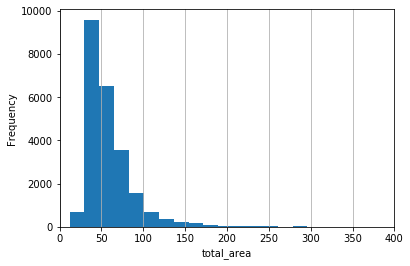

In [398]:
hist_1 = df.total_area.plot.hist(bins = 50, xlim = (0,400))
hist_1.xaxis.grid(True)
hist_1.set_xlabel('total_area')

Text(0.5, 0, 'last_price')

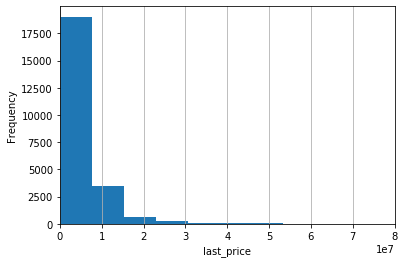

In [399]:
hist_2 = df.last_price.plot.hist(bins = 100, xlim = (0,80000000))
hist_2.xaxis.grid(True)
hist_2.set_xlabel('last_price')

Text(0.5, 0, 'rooms')

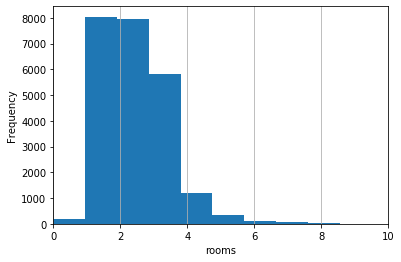

In [400]:
hist_3 = df.rooms.plot.hist(bins = 20, xlim = (0,10))
hist_3.xaxis.grid(True)
hist_3.set_xlabel('rooms')

Text(0.5, 0, 'ceiling_height')

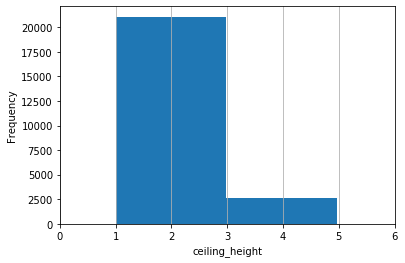

In [401]:
hist_4 = df.ceiling_height.plot.hist(bins = 50, xlim = (0,6))
hist_4.xaxis.grid(True)
hist_4.set_xlabel('ceiling_height')

Построим гистограмму признака days_exposition - время продажи квартиры в днях.

Text(0.5, 0, 'days_exposition')

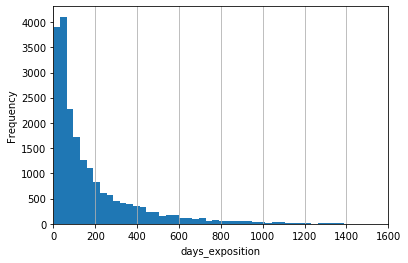

In [402]:
hist_5 = df.days_exposition.plot.hist(bins = 50, xlim = (0,1600))
hist_5.xaxis.grid(True)
hist_5.set_xlabel('days_exposition')

Определим среднее и медиану признака days_exposition.

In [403]:
mean_1 = df.days_exposition.mean()
median_1 = df.days_exposition.median()
mean_1, median_1

(180.88863436982163, 95.0)

Чтобы ответить на вопрос:"Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?", построить диаграмму "ящик с усами".

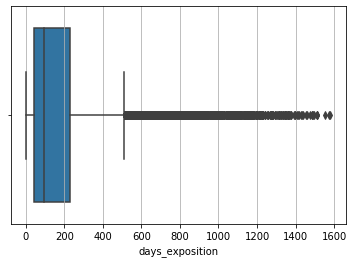

In [404]:
box_1 = sns.boxplot(df['days_exposition'])
box_1.xaxis.grid(True)
box_1

In [405]:
q_25 = df.days_exposition.quantile(0.25)
q_50 = df.days_exposition.quantile(0.5)
q_75 = df.days_exposition.quantile(0.75)
q_25, q_50, q_75

(45.0, 95.0, 232.0)

Исходя из рассчитанных квартилей, можно сделать вывод, что если продажа длится более 232 дней, то данную продажу можно считать долгой. Если продажа длилась 45 дней и менее, то это быстрая продажа.

Далее необходимо избавиться от выбросов. Нужно найти их в каждом параметре

Удалим записи, имеющие в признаке ceiling_height значения больше 10.

In [407]:
df = df.loc[df['ceiling_height'] < 10]
df = df.reset_index()
df = df.drop(['index'], axis = 1)

Далее необходимо выяснить, какие факторы больше всего влияют на стоимость квартиры?

Для этого построим тепловую карту корреляций? создав промужеточный датафрейм, содержащий только числовые столбцы

In [427]:
df_1 = df[['last_price', 'total_area', 'rooms', 'cityCenters_nearest', 'floor_1', 'day_of_week', 'month', 'ponds_nearest', 'year']]

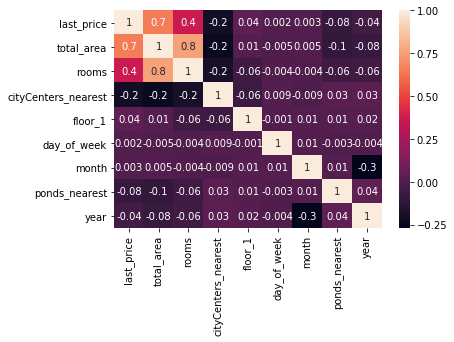

In [428]:
map_1 = sns.heatmap(df_1.corr(), annot = True, fmt = '.1g')
map_1

Анализируя выше приведенный график, делаем вывод, что цена зависит только от общей площади квартиры.

Далее необходимо выбрать 10 населённых пунктов с наибольшим числом объявлений, посчитать среднюю цену квадратного метра в этих населённых пунктах. Выделите среди них населённые пункты с самой высокой и низкой стоимостью жилья.

In [436]:
df_2 = df.groupby(['locality_name'], as_index = False).count()
df_2 = df_2.sort_values(['last_price'], ascending = False) 
df_2 = df_2.reset_index()
df_2 = df_2.drop(['index'], axis = 1)
df_2 = df_2.loc[:9]
df_2

,locality_name,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,day_of_week,month,year,floor_1,living_area/total_area,kitchen_area/total_area
0,Санкт-Петербург,15706,15706,15706,15706,15706,15706,15636,14566,15706,...,15645,7976,13626,15706,15706,15706,15706,15706,14566,14330
1,Мурино,588,588,588,588,588,588,584,522,588,...,2,2,549,588,588,588,588,588,522,479
2,Кудрово,472,472,472,472,472,472,470,424,472,...,0,0,441,472,472,472,472,472,424,389
3,Шушары,440,440,440,440,440,440,439,404,440,...,436,152,408,440,440,440,440,440,404,398
4,Всеволожск,398,398,398,398,398,398,398,371,398,...,0,0,339,398,398,398,398,398,371,357
5,Пушкин,369,369,369,369,369,369,369,345,369,...,369,177,307,369,369,369,369,369,345,338
6,Колпино,338,338,338,338,338,338,338,328,338,...,337,190,308,338,338,338,338,338,328,322
7,Парголово,327,327,327,327,327,327,327,301,327,...,327,56,302,327,327,327,327,327,301,289
8,Гатчина,306,306,306,306,306,306,306,291,306,...,0,0,267,306,306,306,306,306,291,294
9,Выборг,237,237,237,237,237,237,237,193,237,...,0,0,208,237,237,237,237,237,193,201


In [449]:
df_2 = df[['locality_name', 'last_price', 'price_per_square_meter']]
dict_1 = ['Санкт-Петербург', 'Мурино', 'Кудрово', 'Шушары', 'Всеволожск', 'Пушкин', 'Колпино',
                           'Парголово', 'Гатчина', 'Выборг']
df_2 = df_2[df_2['locality_name'].isin(dict_1)]
df_2 = df_2.groupby(['locality_name'], as_index = False) \
    .aggregate({'last_price': 'mean', 'price_per_square_meter': 'mean'}) \
    .rename(columns = {'last_price': 'mean_last_price', 'price_per_square_meter': 'mean_price_per_square_meter'}) \
    .sort_values(['mean_price_per_square_meter'], ascending = False) 
df_2

,locality_name,mean_last_price,mean_price_per_square_meter
8,Санкт-Петербург,8.064238e+06,114827.500764
7,Пушкин,6.469036e+06,103125.373984
4,Кудрово,4.358688e+06,95324.476695
6,Парголово,4.488075e+06,90175.489297
5,Мурино,3.679409e+06,86064.363946
9,Шушары,4.108082e+06,78676.904545
3,Колпино,3.964021e+06,75424.150888
2,Гатчина,3.487972e+06,68757.225490
0,Всеволожск,3.789068e+06,68654.007538
1,Выборг,3.250983e+06,58141.489451


Как видно по таблице, наиболее дорогое жилье находится в Санкт-Петербурге.

Следжующим шагом нужно изучить предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Необходимо выделить квартиры в Санкт-Петербурге и выяснить, какая область входит в центр. 

Для этого создадим столбец с расстоянием до центра в километрах и посчитаем среднюю цену для каждого километра. Построим график: он должен показывать, как цена зависит от удалённости от центра. Определим границу, где график сильно меняется — это и будет центральная зона.

In [459]:
df_3 = df[['locality_name', 'cityCenters_nearest', 'last_price']]
dict_2 = ['Санкт-Петербург']
df_3 = df_3[df_3['locality_name'].isin(dict_2)]
df_3 = df_3.drop(['locality_name'], axis = 1)
df_3['cityCenters_nearest'] = df_3['cityCenters_nearest'] / 1000
df_3['cityCenters_nearest'] = df_3.cityCenters_nearest.round(0)
df_3 = df_3.groupby(['cityCenters_nearest'], as_index = False) \
    .aggregate({'last_price': 'mean'}) \
    .rename(columns = {'last_price': 'mean_last_price'}) \
    .sort_values(['mean_last_price'], ascending = False) 
df_3['mean_last_price'] = df_3['mean_last_price'] / 1000000
df_3 = df_3.rename(columns = {'mean_last_price': 'mean_last_price_mln'})
df_3

,cityCenters_nearest,mean_last_price_mln
0,0.0,31.449116
1,1.0,21.206721
2,2.0,17.788320
6,6.0,15.338418
7,7.0,14.775153
5,5.0,14.499121
4,4.0,13.309091
3,3.0,11.135540
8,8.0,9.969961
27,27.0,8.300000


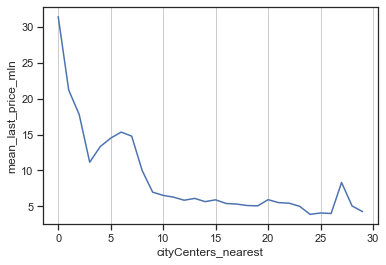

In [461]:
graph_1 = sns.lineplot(x = df_3.cityCenters_nearest, y = df_3.mean_last_price_mln)
graph_1.xaxis.grid(True)
graph_1

Таким образом, видим, что центр Санкт-Петербурга имеет радиус 3 километра.

Выделим сегмент квартир в центре. Проанализируем эту территорию и выделим факторы, которые влияют на стоимость квартиры. Отличаются ли данные выводы от общих выводов по всему городу?

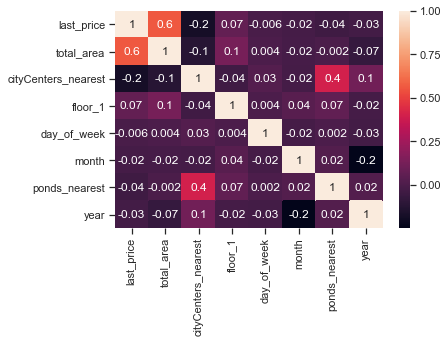

In [472]:
df_4 = df
df_4 = df_4[df_4['locality_name'].isin(dict_2)]
df_4 = df_4.drop(['locality_name'], axis = 1)
df_4['cityCenters_nearest'] = df_4['cityCenters_nearest'] / 1000
df_4['cityCenters_nearest'] = df_4.cityCenters_nearest.round(0)
df_4 = df_4.loc[df_4['cityCenters_nearest'] <= 3]
df_4 = df_4.reset_index()
df_4 = df_4.drop(['index'], axis = 1)
df_5 = df_4[['last_price', 'total_area', 'cityCenters_nearest', 'floor_1', 'day_of_week', 'month', 'ponds_nearest', 'year']]
map_2 = sns.heatmap(df_5.corr(), annot = True, fmt = '.1g')
map_2

Проанализировав данный график, видим, что зависимость между общей площадью квартиры и ценой гораздо ниже в центре города, чем в целом по городу.